In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train = train_data.flow_from_directory(
    r'D:\python\SignLanguageRecognition\dataset',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid = train_data.flow_from_directory(
    r'D:\python\SignLanguageRecognition\dataset',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 28800 images belonging to 36 classes.
Found 7200 images belonging to 36 classes.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(36, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train, validation_data=valid, epochs=10)

model.save('model/asl_model.h5')


C:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 636s 704ms/step - accuracy: 0.2750 - loss: 2.6549 - val_accuracy: 0.3907 - val_loss: 2.7169
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 230s 256ms/step - accuracy: 0.7984 - loss: 0.6667 - val_accuracy: 0.4756 - val_loss: 2.4926
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 222s 247ms/step - accuracy: 0.8729 - loss: 0.4114 - val_accuracy: 0.5094 - val_loss: 2.4589
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 220s 244ms/step - accuracy: 0.8983 - loss: 0.3309 - val_accuracy: 0.5331 - val_loss: 2.4563
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 215s 239ms/step - accuracy: 0.9204 - loss: 0.2535 - val_accuracy: 0.5389 - val_loss: 2.6141
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 1877s 2s/step - accuracy: 0.9300 - loss: 0.2220 - val_accuracy: 0.5639 - val_loss: 2.5071
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 371s 412ms/step - accuracy: 0.9424 - loss: 0.1878 - val_accuracy: 0.5440 - val_loss: 2.6350
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 269s 299ms/step - accuracy: 0.9448 - l

In [ ]:
import cv2
import threading
import numpy as np
import pyttsx3
import queue
from tensorflow.keras.models import load_model

# Load the model
model = load_model('model/asl_model.h5')
label_map = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ")  # Update based on your labels

# Text-to-speech engine
engine = pyttsx3.init()
engine.setProperty('rate', 150)
engine.setProperty('volume', 1.0)

# Queue for speaking letters
speech_queue = queue.Queue()

# Current prediction
current_prediction = ""
last_spoken = ""

# Text-to-speech worker thread (safe)
def tts_worker():
    while True:
        text = speech_queue.get()
        if text is None:
            break
        engine.say(text)
        engine.runAndWait()
        speech_queue.task_done()

# Start TTS thread
tts_thread = threading.Thread(target=tts_worker, daemon=True)
tts_thread.start()

# Predict function
def predict_frame(frame):
    global current_prediction, last_spoken

    img = cv2.resize(frame, (64, 64)) / 255.0
    img = img.reshape(1, 64, 64, 3)

    preds = model.predict(img)
    label = label_map[np.argmax(preds)]
    current_prediction = label

    # Speak only if different from last
    if label != last_spoken:
        speech_queue.put(label)
        last_spoken = label

# Webcam
cap = cv2.VideoCapture(0)
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % 5 == 0:
        threading.Thread(target=predict_frame, args=(frame.copy(),)).start()

    cv2.putText(frame, f"Prediction: {current_prediction}", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("Sign Language Recognition", frame)
    frame_count += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
speech_queue.put(None)
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [1]:
# 1. Imports
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 2. Load Dataset
DATA_DIR = r'D:\python\SignLanguageRecognition\dataset'
IMG_SIZE = 64

data = []
labels = []

for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                img = cv2.imread(file_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(folder)
            except:
                print(f"Error reading {file_path}")

print(f"Total samples: {len(data)}")

# 3. Preprocess Data


Total samples: 36000


In [2]:
X = np.array(data) / 255.0  # Normalize
y = np.array(labels)

# One-hot encode labels
encoder = LabelBinarizer()
y_encoded = encoder.fit_transform(y)

# Save label mapping
import pickle
with open("model/label_map.pkl", "wb") as f:
    pickle.dump(encoder, f)

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



In [3]:
# 5. Build Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(encoder.classes_), activation='softmax')
])

# 6. Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



C:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 138s 144ms/step - accuracy: 0.3703 - loss: 2.2774 - val_accuracy: 0.9696 - val_loss: 0.1157
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 154s 158ms/step - accuracy: 0.9277 - loss: 0.2238 - val_accuracy: 0.9914 - val_loss: 0.0366
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 178s 197ms/step - accuracy: 0.9624 - loss: 0.1135 - val_accuracy: 0.9939 - val_loss: 0.0202
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 158s 175ms/step - accuracy: 0.9713 - loss: 0.0882 - val_accuracy: 0.9965 - val_loss: 0.0131
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 151s 168ms/step - accuracy: 0.9792 - loss: 0.0642 - val_accuracy: 0.9942 - val_loss: 0.0177
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 192s 156ms/step - accuracy: 0.9823 - loss: 0.0539 - val_accuracy: 0.9982 - val_loss: 0.0067
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 130s 145ms/step - accuracy: 0.9840 - loss: 0.0475 - val_accuracy: 0.9982 - val_loss: 0.0071
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 131s 146ms/step - accuracy: 0.9865 -

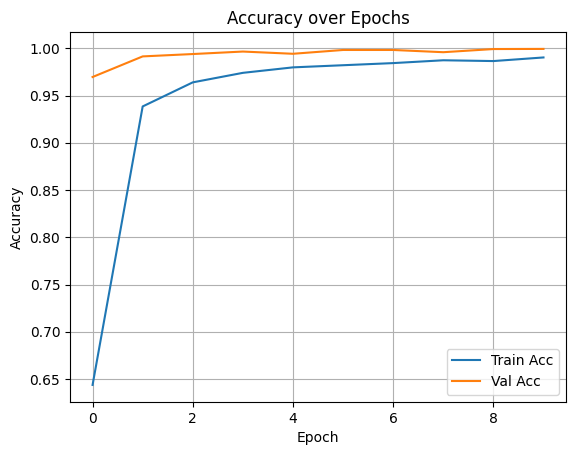

In [4]:
# 7. Train
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

# 8. Save Model
import os
os.makedirs("model", exist_ok=True)
model.save("model/asl_model.h5")

# 9. Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
